# Results OOD FMNIST and MNIST with BALD vs EvalBALD Ablation Visualizations
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files("./results/ood_fmnist_and_mnist_bald_vs_evalbald")

In [ ]:
larger_results = load_laaos_files("./results/ood_fmnist_and_mnist_bald_vs_evalbald_larger_evalset")

In [ ]:
results.update(larger_results)
del larger_results

In [ ]:
get_any(results).config

_config(seed=1256, uniform_ood=True, id_dataset_type='batchbald_redux.fast_mnist.FastFashionMNIST', ood_dataset_type='batchbald_redux.fast_mnist.FastMNIST', initial_training_set_size=20, validation_set_size=1024, evaluation_set_size=256, id_repetitions=1, ood_repetitions=1, add_dataset_noise=False, validation_split_random_state=0, acquisition_size=5, max_training_set=200, num_pool_samples=100, num_validation_samples=20, num_training_samples=1, num_patience_epochs=3, max_training_epochs=30, training_batch_size=64, device='cuda', min_samples_per_epoch=5056, acquisition_function='batchbald_redux.acquisition_functions.BatchEvalBALD', train_eval_model='batchbald_redux.train_eval_model.TrainSelfDistillationEvalModel', model_optimizer_factory='batchbald_redux.models.MnistOptimizerFactory', acquisition_function_args=None, temperature=8)

In [ ]:
list(results.keys())

['/experiment_ood_job_21_2021-05-27-125214.py',
 '/experiment_ood_job_12_2021-05-27-114955.py',
 '/experiment_ood_job_36_2021-05-27-151144.py',
 '/experiment_ood_job_7_2021-05-27-114940.py',
 '/experiment_ood_job_31_2021-05-27-144942.py',
 '/experiment_ood_job_39_2021-05-27-161836.py',
 '/experiment_ood_job_16_2021-05-27-123006.py',
 '/experiment_ood_job_35_2021-05-27-150911.py',
 '/experiment_ood_job_25_2021-05-27-135302.py',
 '/experiment_ood_job_27_2021-05-27-140759.py',
 '/experiment_ood_job_8_2021-05-27-114950.py',
 '/experiment_ood_job_11_2021-05-27-115011.py',
 '/experiment_ood_job_37_2021-05-27-152024.py',
 '/experiment_ood_job_29_2021-05-27-143044.py',
 '/experiment_ood_job_18_2021-05-27-123248.py',
 '/experiment_ood_job_32_2021-05-27-145615.py',
 '/experiment_ood_job_14_2021-05-27-114956.py',
 '/experiment_ood_job_5_2021-05-26-223529.py',
 '/experiment_ood_job_22_2021-05-27-132856.py',
 '/experiment_ood_job_38_2021-05-27-160312.py',
 '/experiment_ood_job_34_2021-05-27-150724.

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,21,1622116334
1,12,1622112595
2,36,1622124704
3,7,1622112580
4,31,1622123382
...,...,...
75,24,1622156281
76,5,1622148078
77,18,1622153763
78,27,1622158119


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

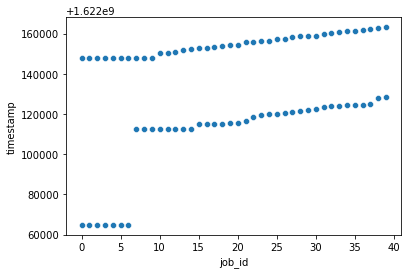

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd

In [ ]:
seed_acq_size_function_result = {}

for name, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue
    
    config = result.config
    key = (config.seed, config.uniform_ood, config.id_dataset_type, config.ood_dataset_type, config.acquisition_size, config.acquisition_function, config.evaluation_set_size)
    if key in seed_acq_size_function_result:
        print(key, name)        
        print(seed_acq_size_function_result[key].config)
        print(config)
        print()
        
    seed_acq_size_function_result[key] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(80, 80)

In [ ]:
results.keys()

dict_keys(['/experiment_ood_job_21_2021-05-27-125214.py', '/experiment_ood_job_12_2021-05-27-114955.py', '/experiment_ood_job_36_2021-05-27-151144.py', '/experiment_ood_job_7_2021-05-27-114940.py', '/experiment_ood_job_31_2021-05-27-144942.py', '/experiment_ood_job_39_2021-05-27-161836.py', '/experiment_ood_job_16_2021-05-27-123006.py', '/experiment_ood_job_35_2021-05-27-150911.py', '/experiment_ood_job_25_2021-05-27-135302.py', '/experiment_ood_job_27_2021-05-27-140759.py', '/experiment_ood_job_8_2021-05-27-114950.py', '/experiment_ood_job_11_2021-05-27-115011.py', '/experiment_ood_job_37_2021-05-27-152024.py', '/experiment_ood_job_29_2021-05-27-143044.py', '/experiment_ood_job_18_2021-05-27-123248.py', '/experiment_ood_job_32_2021-05-27-145615.py', '/experiment_ood_job_14_2021-05-27-114956.py', '/experiment_ood_job_5_2021-05-26-223529.py', '/experiment_ood_job_22_2021-05-27-132856.py', '/experiment_ood_job_38_2021-05-27-160312.py', '/experiment_ood_job_34_2021-05-27-150724.py', '/exp

In [ ]:
experiment_data = []

for file, result in results.items():
    try:
        if not hasattr(result, "config"):
            print(file, "empty")
            continue
        if hasattr(result, "exception"):
            print(file, "exception")
            continue
            
        config = result.config

        ood_type = "uniform_target_ood" if config.uniform_ood else "rejection_ood"
        dataset_prefix = len("batchbald_redux.fast_mnist.Fast")
        dataset_combo = f"{config.id_dataset_type[dataset_prefix:]} (iD) + {config.ood_dataset_type[dataset_prefix:]} (OoD)"
        
        acquisition_size = config.acquisition_size
        acquisition_function = config.acquisition_function[len("batchbald_redux.acquisition_functions.") :]
        num_pool_samples = config.num_pool_samples
        evaluation_set_size = len(result.evaluation_set_indices)
        initial_set_size = len(result.initial_training_set_indices)
                
        seed = config.seed

        if acquisition_function == "Random":
            acquisition_sizes = [5]
        else:
            acquisition_sizes = [acquisition_size]
            
        if acquisition_function == "BatchBALD":
            evaluation_set_size = 0

        # if acquisition_function == "Random":
        #     num_pool_samples = [10, 20, 50, 100]
        # else:
        num_pool_samples = [num_pool_samples]

        for nps in num_pool_samples:
            for acquisition_size in acquisition_sizes:
                if (
                    initial_set_size
                    + sum(1 if hasattr(step, "evaluation_metrics") else 0 for step in result.active_learning_steps)
                    * config.acquisition_size
                    < 150
                ):
                    print(len(result.active_learning_steps), file)
                    continue

                num_acquired_ood_samples = 0
                for i, step in enumerate(result.active_learning_steps):
                    if not hasattr(step, "evaluation_metrics"):
                        print(step)
                        break
                    if i != len(result.active_learning_steps) - 1 and not hasattr(step, "acquisition"):
                        print(file, i)
                        break

                    active_learning_acquisitions = i * config.acquisition_size
                    total_acquisitions = initial_set_size + active_learning_acquisitions
                    accuracy = step.evaluation_metrics.accuracy
                        
                    experiment_data.append(
                        dict(
                            dataset_combo=dataset_combo,
                            ood_type=ood_type,
                            acquisition_function=acquisition_function,
                            acquisition_size=acquisition_size,
                            num_pool_samples=nps,
                            total_acquisitions=total_acquisitions,
                            accuracy=accuracy,
                            evaluation_set_size=evaluation_set_size,
                            seed=seed,
                            num_acquired_ood_samples=num_acquired_ood_samples,
                            active_learning_acquisitions=active_learning_acquisitions,
                            acquired_ood_sample_ratio=num_acquired_ood_samples/total_acquisitions if total_acquisitions > 0 else 0
                        )
                    )
                    
                    if hasattr(step, "acquisition"):
                        for label in step.acquisition.labels:
                            if ood_type == "rejection_ood":
                                if label == -1:
                                    num_acquired_ood_samples+=1
                            else:
                                if all(t < 0.5 for t in label):
                                    num_acquired_ood_samples+=1
                    elif i != len(result.active_learning_steps) - 1:
                        raise Exception("'acquisition' not found in step!")
    except:
        print(file)
        raise

In [ ]:
df = pd.DataFrame.from_records(experiment_data)
df["training_set_size"] = df["total_acquisitions"] - df["num_acquired_ood_samples"]
df["smoothed_training_set_size"] = (df["total_acquisitions"] - df["num_acquired_ood_samples"])//5*5

In [ ]:
df

,dataset_combo,ood_type,acquisition_function,acquisition_size,num_pool_samples,total_acquisitions,accuracy,evaluation_set_size,seed,num_acquired_ood_samples,active_learning_acquisitions,acquired_ood_sample_ratio,training_set_size,smoothed_training_set_size
0,FashionMNIST (iD) + MNIST (OoD),uniform_target_ood,BatchEvalBALD,5,100,20,0.5878,250,1256,0,0,0.000000,20,20
1,FashionMNIST (iD) + MNIST (OoD),uniform_target_ood,BatchEvalBALD,5,100,25,0.5971,250,1256,4,5,0.190476,21,20
2,FashionMNIST (iD) + MNIST (OoD),uniform_target_ood,BatchEvalBALD,5,100,30,0.6333,250,1256,6,10,0.250000,24,20
3,FashionMNIST (iD) + MNIST (OoD),uniform_target_ood,BatchEvalBALD,5,100,35,0.6125,250,1256,6,15,0.206897,29,25
4,FashionMNIST (iD) + MNIST (OoD),uniform_target_ood,BatchEvalBALD,5,100,40,0.6363,250,1256,6,20,0.176471,34,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3396,MNIST (iD) + FashionMNIST (OoD),uniform_target_ood,BatchBALD,5,100,180,0.9308,0,1265,2,160,0.011236,178,175
3397,MNIST (iD) + FashionMNIST (OoD),uniform_target_ood,BatchBALD,5,100,185,0.9289,0,1265,2,165,0.010929,183,180
3398,MNIST (iD) + FashionMNIST (OoD),uniform_target_ood,BatchBALD,5,100,190,0.9399,0,1265,2,170,0.010638,188,185
3399,MNIST (iD) + FashionMNIST (OoD),uniform_target_ood,BatchBALD,5,100,195,0.9393,0,1265,2,175,0.010363,193,190


In [ ]:
df.acquisition_size.unique()

array([5])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("active_learning_acquisitions == 0").groupby(["dataset_combo", "ood_type", "acquisition_size", "evaluation_set_size"])["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

dataset_combo                    ood_type            acquisition_size  evaluation_set_size  acquisition_function
FashionMNIST (iD) + MNIST (ooD)  rejection_ood       5                 0                    BatchBALD               9
                                                                       10                   BatchEvalBALD           3
                                                                       250                  BatchEvalBALD           3
                                                                       2000                 BatchEvalBALD           5
                                 uniform_target_ood  5                 0                    BatchBALD               9
                                                                       10                   BatchEvalBALD           3
                                                                       250                  BatchEvalBALD           3
                                                             

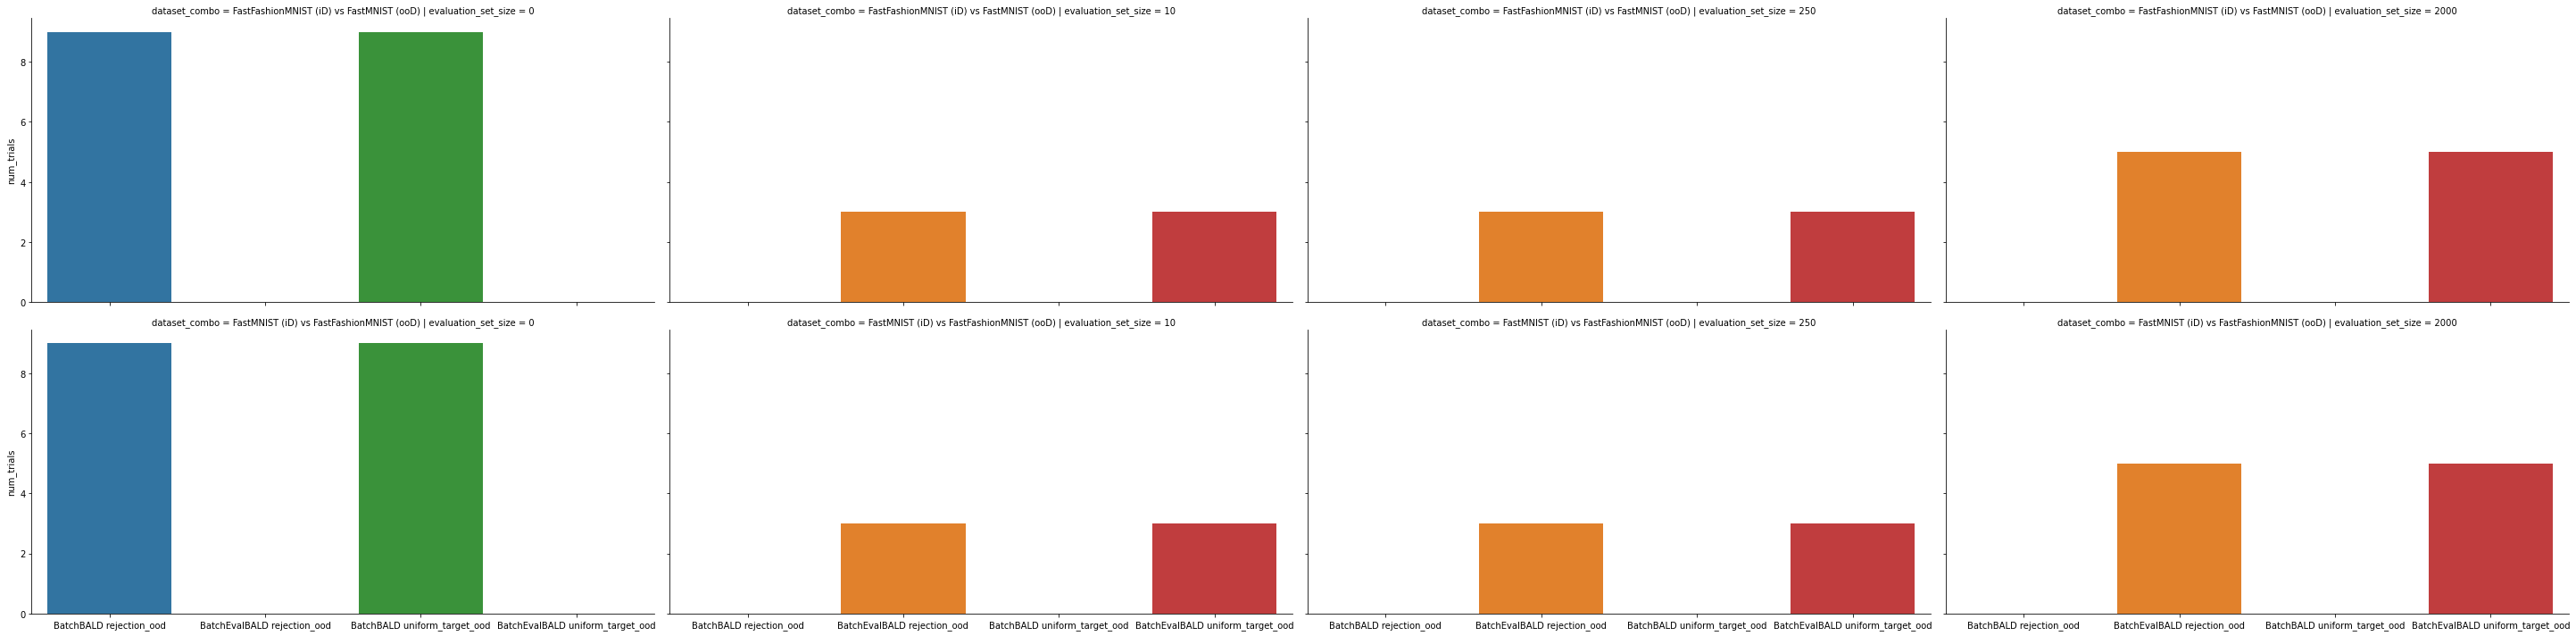

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x=num_trials_by_acquisition_size_and_function["acquisition_function"] + " " + num_trials_by_acquisition_size_and_function["ood_type"],
    col="evaluation_set_size",
    row="dataset_combo",
    aspect=2,
)
grd.fig.patch.set_alpha(1)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc

# MatPlotLib style and settings (that also affect PlotNine)

rc("text", usetex=False)
rc(
    "text.latex",
    preamble=r"""
\usepackage{bbm}
\usepackage{amsmath}
\usepackage{amsfonts}
""",
)

In [ ]:
sns.set_style("whitegrid")
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [ ]:
def plt_save(grd, output_path, **kwargs):
    # plt.style.use("seaborn-colorblind")
    grd.savefig(output_path, transparent=True, bbox_inches="tight", pad_inches=0, **kwargs)

In [ ]:
dashes = {0: "", 10: (1,1), 250: (2,1), 2000: ""}
#sizes = {0: 1, 10: 1, 250: 1, 2000: 2}

In [ ]:
nice_acquisition_function_map = {
    "Random": "Uniform",
    "BALD": "BALD",
    "BatchEvalBALD": "BatchEPIG-BALD",
    "BatchBALD": "BatchBALD",
}


def to_nice_acquisition_function(n):
    return nice_acquisition_function_map[n]

In [ ]:
df["Acquisition Function"] = df.acquisition_function.map(nice_acquisition_function_map)
df["nice_ood_type"] = df.ood_type.map(dict(rejection_ood="OoD Rejection", uniform_target_ood="OoD Exposure"))
df["Evaluation Set Size"] = df.evaluation_set_size

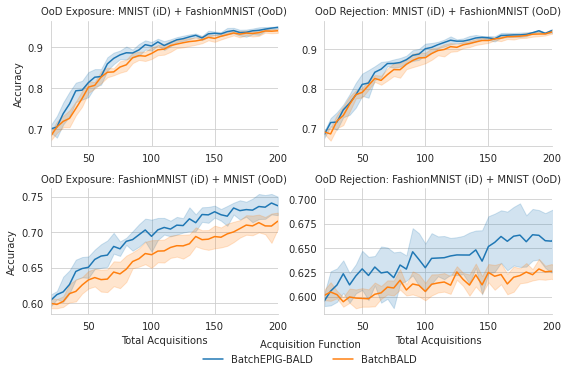

In [ ]:
grd = sns.relplot(
    x="total_acquisitions",
    y="accuracy",
    col="nice_ood_type",
    #style="Evaluation Set Size",
    row="dataset_combo",
    hue="Acquisition Function",
    data=df[df["evaluation_set_size"].isin([0,2000])], #.sample(frac=0.05),
    kind="line",
    height=2.5,
    aspect=1.61,
    dashes=dashes,
    #size=sizes,
    facet_kws=dict(sharey=False,sharex=False),
    hue_order=list(
        map(
            to_nice_acquisition_function,
            [
                "BatchEvalBALD",
                "BatchBALD",                
            ],
        )
    ),
)

#grd.fig.patch.set_alpha(1)
grd.set_xlabels("Total Acquisitions")
grd.set_ylabels("Accuracy")
grd.set_titles("{col_name}: {row_name}")
grd.tight_layout()

for i in range(2):
    for j in range(2):
        grd.axes[i][j].set_xlim(20,200)

handles, labels = grd.axes[0][0].get_legend_handles_labels()
grd._legend.remove()
grd.fig.legend(handles, labels, ncol=2, loc='lower center', title="Acquisition Function",
                bbox_to_anchor=(0.45, -0.05), frameon=False)

In [ ]:
plt_save(grd, "plots/ood_mnist_and_fmnist.pdf")

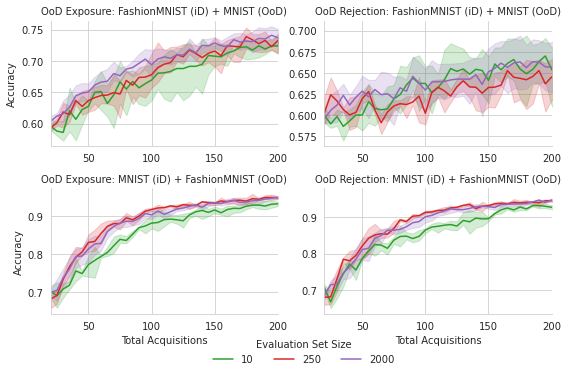

In [ ]:
grd = sns.relplot(
    x="total_acquisitions",
    y="accuracy",
    col="nice_ood_type",
    hue="Evaluation Set Size",
    row="dataset_combo",
    #hue="Acquisition Function",
    data=df[(df["evaluation_set_size"] != 0) & (df["acquisition_function"] == "BatchEvalBALD")], #.sample(frac=0.05),
    kind="line",
    height=2.5,
    aspect=1.61,
    #dashes=dashes,
    #size=sizes,
    facet_kws=dict(sharey=False,sharex=False),
    palette=sns.color_palette()[2:2+3],
    #hue_order=[10, 250, 2000],
    # hue_order=list(
    #     map(
    #         to_power_bald_nice_acquisition_function,
    #         [
    #             "BatchEvalBALD",
    #             "BatchBALD",                
    #         ],
    #     )
    # ),
)

#grd.fig.patch.set_alpha(1)
grd.set_xlabels("Total Acquisitions")
grd.set_ylabels("Accuracy")
grd.set_titles("{col_name}: {row_name}")
grd.tight_layout()

for i in range(2):
    for j in range(2):
        grd.axes[i][j].set_xlim(20,200)

handles, labels = grd.axes[0][0].get_legend_handles_labels()
grd._legend.remove()
grd.fig.legend(handles, labels, ncol=3, loc='lower center', title="Evaluation Set Size",
                bbox_to_anchor=(0.45, -0.05), frameon=False)

In [ ]:
plt_save(grd, "plots/ood_mnist_and_fmnist_eval_set_ablation.pdf")

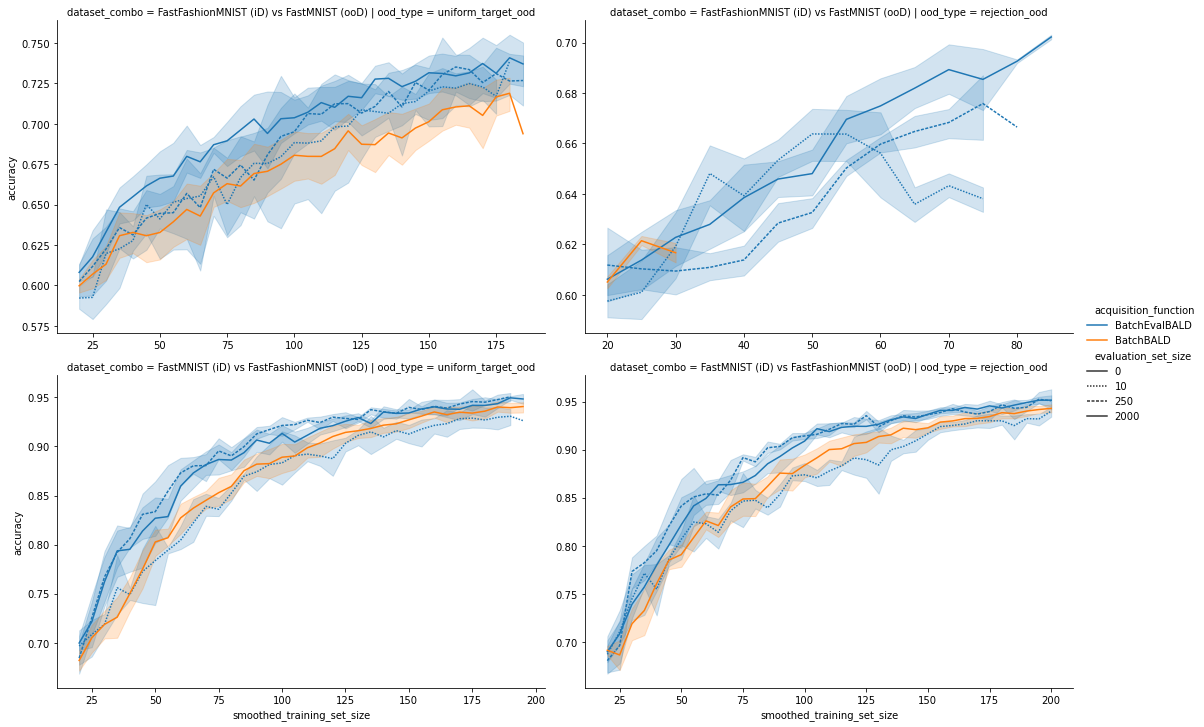

In [ ]:
grd = sns.relplot(
    x="smoothed_training_set_size",
    y="accuracy",
    col="ood_type",
    style="evaluation_set_size",
    row="dataset_combo",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
    aspect=1.5,
    dashes=dashes,
    facet_kws=dict(sharey=False,sharex=False)
)

grd.fig.patch.set_alpha(1)

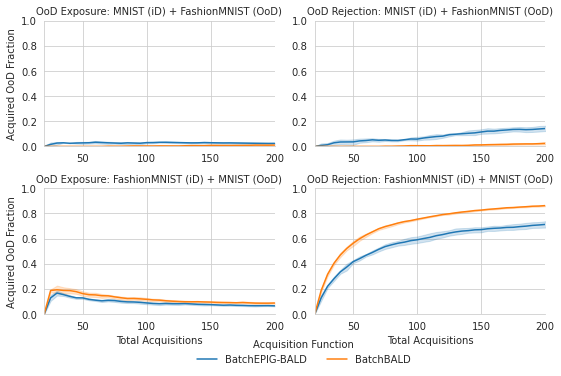

In [ ]:
grd = sns.relplot(
    x="total_acquisitions",
    y="acquired_ood_sample_ratio",
    col="nice_ood_type",
    #style="Evaluation Set Size",
    row="dataset_combo",
    hue="Acquisition Function",
    data=df[df["evaluation_set_size"].isin([0,2000])], #.sample(frac=0.01),
    kind="line",
    height=2.5,
    aspect=1.61,
    dashes=dashes,
    facet_kws=dict(sharey=False,sharex=False),
    hue_order=list(
        map(
            to_nice_acquisition_function,
            [
                "BatchEvalBALD",
                "BatchBALD",                
            ],
        )
    ),
)

#grd.fig.patch.set_alpha(1)
grd.set_xlabels("Total Acquisitions")
grd.set_ylabels("Acquired OoD Fraction")
grd.set_titles("{col_name}: {row_name}")
grd.tight_layout()

for i in range(2):
    for j in range(2):
        grd.axes[i][j].set_ylim(0,1.)
        grd.axes[i][j].set_xlim(20,200)

handles, labels = grd.axes[0][0].get_legend_handles_labels()
grd._legend.remove()
grd.fig.legend(handles, labels, ncol=2, loc='lower center', title="Acquisition Function",
                bbox_to_anchor=(0.45, -0.05), frameon=False)

In [ ]:
plt_save(grd, "plots/ood_mnist_and_fmnist_ratio.pdf")

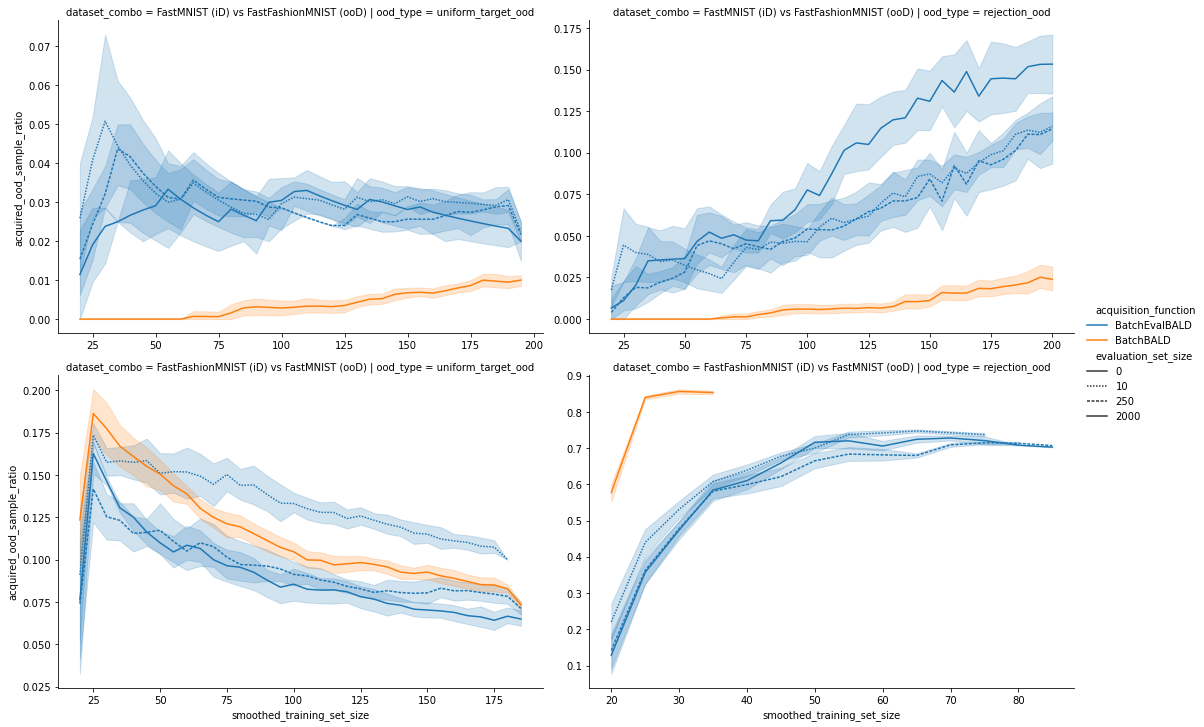

In [ ]:
grd = sns.relplot(
    x="smoothed_training_set_size",
    y="acquired_ood_sample_ratio",
    col="ood_type",
    style="evaluation_set_size",
    row="dataset_combo",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
    aspect=1.5,
    dashes=dashes,
    facet_kws=dict(sharey=False,sharex=False)
)

grd.fig.patch.set_alpha(1)

In [ ]:
import qgrid

group_fields = ["dataset_combo", "ood_type", "evaluation_set_size", "acquisition_function"] 

df.sort_values(["seed"] + group_fields + ["total_acquisitions"], inplace=True)

df["max_accuracy"] = df.groupby(["seed"] + group_fields).accuracy.cummax()

df_max_accuracy = df.drop_duplicates(subset=group_fields + ["seed", "max_accuracy"])
#qgrid.show_grid(df_max_accuracy)
df_max_accuracy

,dataset_combo,ood_type,acquisition_function,acquisition_size,num_pool_samples,total_acquisitions,accuracy,evaluation_set_size,seed,num_acquired_ood_samples,active_learning_acquisitions,acquired_ood_sample_ratio,training_set_size,smoothed_training_set_size,max_accuracy
1626,FastMNIST (iD) vs FastFashionMNIST (ooD),uniform_target_ood,BatchEvalBALD,5,100,20,0.7043,10,1234,0,0,0.000000,20,20,0.7043
1628,FastMNIST (iD) vs FastFashionMNIST (ooD),uniform_target_ood,BatchEvalBALD,5,100,30,0.7232,10,1234,2,10,0.066667,28,25,0.7232
1630,FastMNIST (iD) vs FastFashionMNIST (ooD),uniform_target_ood,BatchEvalBALD,5,100,40,0.7502,10,1234,3,20,0.075000,37,35,0.7502
1634,FastMNIST (iD) vs FastFashionMNIST (ooD),uniform_target_ood,BatchEvalBALD,5,100,60,0.7911,10,1234,3,40,0.050000,57,55,0.7911
1635,FastMNIST (iD) vs FastFashionMNIST (ooD),uniform_target_ood,BatchEvalBALD,5,100,65,0.7955,10,1234,3,45,0.046154,62,60,0.7955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3811,FastFashionMNIST (iD) vs FastMNIST (ooD),rejection_ood,BatchBALD,5,100,20,0.5811,0,1317,0,0,0.000000,20,20,0.5811
3812,FastFashionMNIST (iD) vs FastMNIST (ooD),rejection_ood,BatchBALD,5,100,25,0.6217,0,1317,4,5,0.160000,21,20,0.6217
3831,FastFashionMNIST (iD) vs FastMNIST (ooD),rejection_ood,BatchBALD,5,100,120,0.6321,0,1317,90,100,0.750000,30,30,0.6321
3842,FastFashionMNIST (iD) vs FastMNIST (ooD),rejection_ood,BatchBALD,5,100,175,0.6369,0,1317,141,155,0.805714,34,30,0.6369


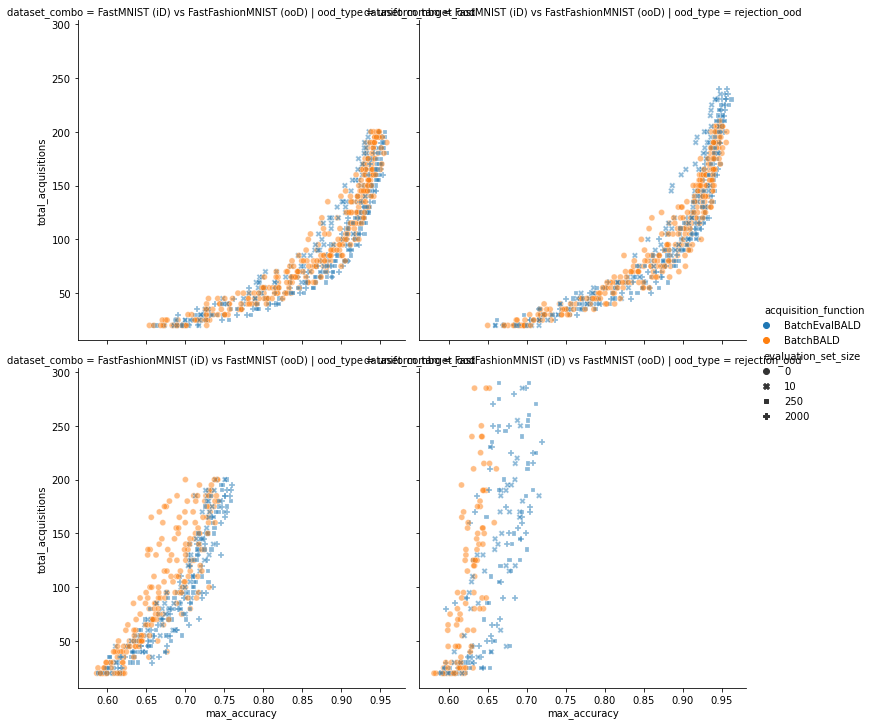

In [ ]:
grd = sns.relplot(
    y="total_acquisitions",
    x="max_accuracy",
    col="ood_type",
    row="dataset_combo",
    hue="acquisition_function",
    style="evaluation_set_size",
    data=df_max_accuracy[df_max_accuracy.acquisition_function != "random"],
    kind="scatter",
    height=5,
    alpha=0.5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
df2 = df[(df.max_accuracy >= 0.90) & (df.acquisition_function != "random")].groupby(["seed"] + group_fields).first()

In [ ]:
df3 = df2.groupby(group_fields).total_acquisitions.quantile([0.25, 0.5, 0.75])
df3

dataset_combo                             ood_type            evaluation_set_size  acquisition_function      
FastMNIST (iD) vs FastFashionMNIST (ooD)  rejection_ood       0                    BatchBALD             0.25     97.5
                                                                                                         0.50    110.0
                                                                                                         0.75    122.5
                                                              10                   BatchEvalBALD         0.25    100.0
                                                                                                         0.50    110.0
                                                                                                         0.75    130.0
                                                              250                  BatchEvalBALD         0.25     90.0
                                                         

In [ ]:
df3.unstack()

0.25  \
dataset_combo                            ood_type           evaluation_set_size acquisition_function          
FastMNIST (iD) vs FastFashionMNIST (ooD) rejection_ood      0                   BatchBALD              97.5   
                                                            10                  BatchEvalBALD         100.0   
                                                            250                 BatchEvalBALD          90.0   
                                                            2000                BatchEvalBALD         100.0   
                                         uniform_target_ood 0                   BatchBALD              95.0   
                                                            10                  BatchEvalBALD         125.0   
                                                            250                 BatchEvalBALD          80.0   
                                                            2000                BatchEvalBALD          80.0   

                                                                                                       0.50  \
dataset_combo                            ood_type           evaluation_set_size acquisition_function          
FastMNIST (iD) vs FastFashionMNIST (ooD) rejection_ood      0                   BatchBALD             110.0   
                                                            10                  BatchEvalBALD         110.0   
                                                            250                 BatchEvalBALD          90.0   
                                                            2000                BatchEvalBALD         100.0   
                                         uniform_target_ood 0                   BatchBALD             100.0   
                                                            10                  BatchEvalBALD         130.0   
                                                            250                 BatchEvalBALD          80.0   
                                                            2000                BatchEvalBALD          90.0   

                                                                                                       0.75  
dataset_combo                            ood_type           evaluation_set_size acquisition_function         
FastMNIST (iD) vs FastFashionMNIST (ooD) rejection_ood      0                   BatchBALD             122.5  
                                                            10                  BatchEvalBALD         130.0  
                                                            250                 BatchEvalBALD          95.0  
                                                            2000                BatchEvalBALD         110.0  
                                         uniform_target_ood 0                   BatchBALD             110.0  
                                                            10                  BatchEvalBALD         135.0  
                                                            250                 BatchEvalBALD          90.0  
                                                            2000                BatchEvalBALD          95.0

In [ ]:
df2 = df[(df.max_accuracy >= 0.67) & (df.dataset_combo != "FastMNIST (iD) vs FastFashionMNIST (ooD)")].groupby(["seed"] + group_fields).first()
df3 = df2.groupby(group_fields).total_acquisitions.quantile([0.25, 0.5, 0.75])
df3.unstack()

0.25  \
dataset_combo                            ood_type           evaluation_set_size acquisition_function          
FastFashionMNIST (iD) vs FastMNIST (ooD) rejection_ood      10                  BatchEvalBALD         120.0   
                                                            250                 BatchEvalBALD          97.5   
                                                            2000                BatchEvalBALD         127.5   
                                         uniform_target_ood 0                   BatchBALD              92.5   
                                                            10                  BatchEvalBALD          65.0   
                                                            250                 BatchEvalBALD          55.0   
                                                            2000                BatchEvalBALD          55.0   

                                                                                                       0.50  \
dataset_combo                            ood_type           evaluation_set_size acquisition_function          
FastFashionMNIST (iD) vs FastMNIST (ooD) rejection_ood      10                  BatchEvalBALD         170.0   
                                                            250                 BatchEvalBALD         120.0   
                                                            2000                BatchEvalBALD         157.5   
                                         uniform_target_ood 0                   BatchBALD             105.0   
                                                            10                  BatchEvalBALD          80.0   
                                                            250                 BatchEvalBALD          70.0   
                                                            2000                BatchEvalBALD          70.0   

                                                                                                        0.75  
dataset_combo                            ood_type           evaluation_set_size acquisition_function          
FastFashionMNIST (iD) vs FastMNIST (ooD) rejection_ood      10                  BatchEvalBALD         190.00  
                                                            250                 BatchEvalBALD         143.75  
                                                            2000                BatchEvalBALD         193.75  
                                         uniform_target_ood 0                   BatchBALD             115.00  
                                                            10                  BatchEvalBALD          80.00  
                                                            250                 BatchEvalBALD          70.00  
                                                            2000                BatchEvalBALD          75.00